In [7]:
import numpy as np
import pandas as pd
# import re
import regex as re

species = pd.read_excel('plant_info.xlsx').set_index('SpeciesName')
species['Features'] = species['Features'].fillna('')

# Tabular features

## Produce

In [8]:
extra_features_df = pd.read_excel("Words before and after traits_v2.xlsx", sheet_name="Words", skiprows=1)
extra_features_df = extra_features_df[:extra_features_df[extra_features_df.Stature.eq('Following words')].index[0]].applymap(lambda s:s.lower().strip() if type(s) == str else s)

extra_features = extra_features_df.to_dict('list')
extra_features = {k.title().replace(' ', ''): [x for x in v if str(x) != 'nan'] for k, v in extra_features.items()}

In [9]:
all_words = extra_features_df.to_numpy().flatten()
# duplicated words
duplicate_words = []
for word in set(all_words):
	if (all_words == word).sum() > 1:
		duplicate_words.append(word)
print(set(duplicate_words).difference({'achene', 'cypsela', 'floret', 'florets', 'stigma-style'}))

{'cypselae', 'achenes', 'stigma-styles', 'cypselas'}


In [10]:
words_to_remove = []
# remove all words starting with petal, flower, fruit, seed with a letter after different from s. Select the entire word up to the first space or punctuation (,;.) excluded
reg_exp = r'(petal|flower|fruit|seed)[a-rt-z]+[^\s;,.\)]'
for i, row in species.Features.items():
	# print(row)
	for word in re.finditer(reg_exp, row):
		words_to_remove.append(word.group())

words_to_remove = list(set(words_to_remove))

In [11]:
unit = '[m|c|d]?m'
# unit = '[m|c|d]m|(?<=\d)m(?!m)'
# 150–400x100–300mm
number = r"(\d+\.?\d*)"
# full_regex = rf"(({number}-)?{number}{unit}?x)?{number}(-{number})?{unit}" ## Supposed to be correct
"""anomaies:
	0.05-0.35-1mx1.5-3-6mm
"""
full_regex = rf"({number}(-{number})?(-{number})?{unit}?x)?({number}(-{number})?(-{number})?{unit}?x)?{number}(-{number})?(-{number})?(-{number})?{unit}"

In [19]:
tmp = []
anomalies = set() # species with anomalies

def extract_features(i, feats:list, wordmeasure_distance=10):
	features = {}
	for feat in feats:
		if len(feat) < 1:
			continue
		feat = feat.replace(',', ' ')
		measures = re.finditer(full_regex, feat)
		for measure in measures:
			found = None
			# measure_position = len(re.findall(r'\s+', feats[0][:measure.span()[0]]))
			for key, values in extra_features.items():
				feat = feat[:-1] if feat[-1] in ['.', ';'] else feat # remove any of .; at the end of the sentence
				matched_word = list(re.finditer( r'\b('+ '|'.join([w for w in set(values)]) + r')\b', feat.lower()))
				if any(matched_word):
					if key != 'Stature': # TODO: Caso up to 3m, petiole 2mm???
						matched_word = [w for w in matched_word if w.span()[0] < measure.span()[0]]
						if not any(matched_word):
							continue # if not stature and measure appears before the word, skip
					matched_word = sorted(matched_word, key=lambda word: word.span()[1] - measure.span()[0])[0]

					# Priorities: Stature > ...
					if found and found[0] == 'Stature':
						continue
					if found and found[0] in ['StamenSize', 'AntherSize', 'StigmaSize', 'StyleSize', 'OvarySize', 'PetioleSize', 'PedicelSize'] and key in ['FlowerSize', 'PetalSize']:
						continue # Place in stamen size, anther size, stygma size, style size, ovary size respectively, ignoring flower and petal size
					if found and found[0] =='InflorescenceSize' and key == 'FlowerSize':
						continue # if inflorencence was already found, skip flower (e.g., "flower stem" associated with inflorescence only)
					if found and found[0] == 'SeedSize' and key=='FruitSize' and not any([w in feat.lower() for w in ['achene', 'cypsela']]):
						continue # If a key word for seed size and e.g. "per fruit" are contained in the string: Place the values in seed size only
					if found and found[0] == 'FruitSize' and key!='SeedSize': # the last condition should be redundant
						continue # word for fruit size is used, except cypsela or achene: Ignore other words and place in fruit size

					this_distance = abs(matched_word.span()[1] - measure.span()[0])
					# this_distance = abs(word_match_position - measure_position)
					if found:
						if (any([w in feat.lower() for w in ['achene', 'cypsela']]) and {key, found[0]} == {'FruitSize', 'SeedSize'}) or\
						   (any([w in feat.lower() for w in ['stigma-style']]) and {key, found[0]} == {'StigmaSize', 'StyleSize'}) or\
						   (any([w in feat.lower() for w in ['floret']]) and {key, found[0]} == {'RayFloretsSize', 'DiskFloretSize'}):
							pass
							# print(f'OK>> Multiple features found ({found}, {key}) in "{feat}"')
						else:
							if this_distance >= found[1]:
								continue
							else:
								# print(found, key, matched_word, measure)
								features[found[0]].remove(found[2])
							anomalies.add(i)
					found = (key, this_distance, measure.group())
					
					if key in features:
						features[key].append(measure.group())
					else:
						features[key] = [measure.group()]
	return pd.Series(features)

In [17]:
def string_preprocessing(s):
	s = s.replace('\xa0', ' ').replace('×', 'x').replace('–', '-').replace('·', '.') # remove non-breaking space and replace multiplication sign with x
	s = re.sub(r'(?<=xcluding)\s+[\w-]+', ' ', s) # remove each word following "excluding" (Mericarps (excluding style) 2.5-3.0 mm should point to "Mericarps")
	s = re.sub(fr'-?\(-?{number}-?\)-?', '', s) # remove all parentesis surrounding a number (e.g. (-1.5))
	s = s.replace('--', '-').replace('-.', '-').replace('..', '.')
	s = s.replace('(', '').replace(')', '')
	s = re.sub(r'\s(c|ca|o)\.', ' foo ', s) # remove all ' c.'
	s = re.sub(r'(?<=\d)\s+(?=[cmd]?m)', '', s) # remove all spaces before measures (mm, cm, dm, m, these strings only if padded by a space)
	s = re.sub(r'\s*-\s*', '-', s) # remove spaces around hyphens
	s = re.sub(r'(?<=\d)\s*\.(?=\d)', '.', s) # remove spaces before dot if followed and preceded by a number
	s = re.sub(r'(?<=\s)\.(?=\d)', '0.', s) # add a 0 before a dot if it is preceded by a space and a "not number" and followed by a number (e.g. foo .5 --> foo 0.5)
	s = re.sub(r'(?<=[\dm])\s*x\s*(?=\d+)', 'x', s) # remove spaces around x in formulas
	s = re.sub(rf'(;\s*)({full_regex})', r' \2', s) # point to any ';' preceding a measure (full_regex) and remove it, without removing the measure
	# now all measures are supposed to have no spaces between number and unit and spaces around them

	s = re.sub(rf'(?<=\d{unit})(\s*long,?\s*)(?={number}{unit})', r'x', s) # remove any 'long' after a measure ("2 mm long X 3 mm wide" --> "2 mm x 3 mm wide")
	s = re.sub(rf'(?<=\d)([m|c|d]m|m(?!m))(?!x)', r'\1 ', s) # fix situation in which a measure is not followed by a space, in the case, add that space
	s = re.sub(r'(?<![\d\sx\.-])(\d)', r' \1', s) # fix the situation in which a measure (the whole number and measure) is not preceded by a space. In the case, add a space before the measure
	s = re.sub(rf'(?<=\s)-(?=\d)', '', s) # remove '-' at the beginning of a measure (e.g. -1.5 --> 1.5)
	s = re.sub(r'(?<=\d\.\d+)(\.\d?)', '', s) # fix the error in which there is a doubled dot in a number (e.g. 1.5.2), in the case, remove the second dot and the eventual numbers after it
	s = re.sub(r'(?<=[a-ln-z])-(?=\d)', ' ', s) # remove all '-' preceded by a letter (different from m) and followed by a number (e.g. to-250mm --> to 250mm)
	s = re.sub(r'(?<![a-z])(l|I)(?=[\s\.-]|\d)', '1', s) # replace all 'l' or "I" characters which should be '1' (e.g. l.5 --> 1.5). This should be followed by a space, a dot, a hyphen, or a number and not preceded by a letter
	return s

In [37]:
features = species.Features.apply(string_preprocessing).str.split(r'(?<!\sc)[.;]\s|;').reset_index().apply(lambda x: extract_features(x.SpeciesName, x.Features), axis=1)
features = features.applymap(lambda x: '; '.join(x) if not isinstance(x, float) else x)
features.index = species.index
features[features.notna().sum(axis=1) > 0].to_csv('processed_features.csv')

## Analysis

In [41]:
processed_features = pd.read_csv('processed_features.csv', index_col=0)

In [48]:
(processed_features.isna().sum(axis=0)/len(processed_features)).sort_values()#.plot.barh(figsize=(10, 5), title='Percentage of missing values per feature')

LeafSize             0.083144
FruitSize            0.308390
Stature              0.373394
SeedSize             0.456538
InflorescenceSize    0.579743
FlowerSize           0.613757
PetioleSize          0.662132
AntherSize           0.678005
PedicelSize          0.721844
StyleSize            0.741497
OvarySize            0.746032
StamenSize           0.779289
LobesSize            0.780045
TubeSize             0.792895
CalyxSize            0.827664
PetalSize            0.833711
SepalSize            0.835223
CorollaSize          0.885865
StigmaSize           0.894936
UtricleSize          0.918367
PappusSize           0.922902
RayFloretsSize       0.933485
DiskFloretSize       0.934240
Lemma                0.934996
Glumes               0.946334
Palea                0.957672
Lodicules            0.961451
dtype: float64

<Axes: title={'center': 'Percentage of missing values per species'}, ylabel='SpeciesName'>

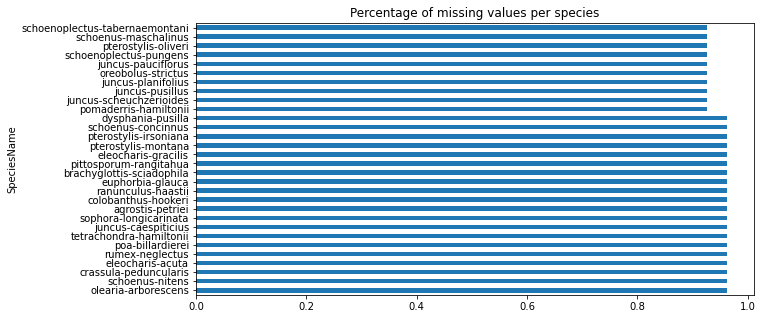

In [52]:
(processed_features.isna().sum(axis=1)/processed_features.shape[1]).sort_values(ascending=False).head(30).plot.barh(figsize=(10, 5), title='Percentage of missing values per species')

In [66]:
processed_features.LeafSize.isna().sum()

110

In [65]:
processed_features.LeafSize.str.split(';').apply(lambda x: sum(['x' in y for y in x]) if not isinstance(x, float) else 0).value_counts()

LeafSize
1    742
0    392
2    160
3     16
4     13
Name: count, dtype: int64

In [28]:
sp = 'myosotis-antarctica'
ft = species.iloc[species.index.get_loc(sp):species.index.get_loc(sp)+1].Features
print(ft.apply(string_preprocessing).str.split(r'(?<!\sc)[.;]\s|;')[0])
ft.apply(string_preprocessing).str.split(r'(?<!\sc)[.;]\s|;').reset_index().apply(lambda x: extract_features(x.SpeciesName, x.Features), axis=1)

['Perennial rosette-leaved herb', 'Rosette leaves 10-20x4-5mm , lamina obovate, obtuse, petiole short, broad', 'hairs on upper surface crowded, long, soft and silky, those of under-surface sparse, glabrate', 'Lateral branches numerous, decumbent, up to 70mm  long, occasionally branched, internodes usually < leaves', 'Stem-leaves similar to rosette-leaves near base, becoming sessile above, bracts foo 5x2mm ', 'Cymes usually simple, few-, bracteate except at extreme tip, internodes, except the lowest, very short', 'pedicels foo 1mm  long', 'Calyx foo 3mm  long, lobes > 1/ 2 length, broad and subacute', 'hairs mostly very long and soft, a few short and closely appressed', 'Corolla blue occasionally white, 2-3mm  diam, tube cylindric, 2mm  long, lobes 1.0-1.5mm  long, ± parallel-sided, narrowing above to obtuse tip', 'filaments very short, anthers < 1mm , wholly included, tips not reaching scales', 'style < calyx, stigma clavate', 'Nutlet 1.1-1.4x0.7-1.0mm , ovate, black.']
('CorollaSize',

,LeafSize,PedicelSize,CalyxSize,CorollaSize,TubeSize,LobesSize,StamenSize,AntherSize,FruitSize
0,"[10-20x4-5mm, 5x2mm]",[1mm],[3mm],[2-3mm],[2mm],[1.0-1.5mm],[],[1mm],[1.1-1.4x0.7-1.0mm]


### IDEA

- Dataset con valori mancanti
- Imputing missing values (dataset per mainland + dataset per isola, ora solo mainland?)
- Confronto distribuzioni isola con mainland

altrimenti
- Metric uncoupling

In [6]:
processed_features.isna().sum() / processed_features.shape[0]

AntherSize           0.800894
CalyxSize            0.850546
CorollaSize          0.914598
FlowerSize           0.722443
FruitSize            0.710526
Glumes               0.961271
InflorescenceSize    0.662860
LeafSize             0.524330
Lemma                0.956802
Lodicules            0.975174
OvarySize            0.856008
Palea                0.972195
PedicelSize          0.790467
PetalSize            0.893247
PetioleSize          0.751241
SeedSize             0.720953
StamenSize           0.960775
Stature              0.763158
StigmaSize           0.944389
StyleSize            0.848064
TubeSize             0.900199
dtype: float64

<Axes: >

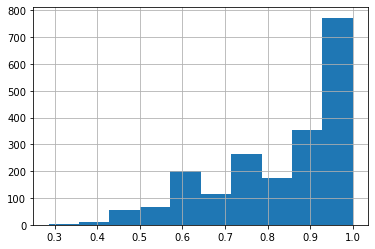

In [10]:
(processed_features.isna().sum(axis=1) / processed_features.shape[1]).sort_values(ascending=False).hist()

# Graph features

In [58]:
for rec in SeqIO.parse(filename, "nexus"):
	print(rec.id)
	print(repr(rec.seq))
	print(len(rec))

In [62]:
from Bio import Phylo
# load graph in format nexus.nex:
# ((((((((((((((((((((((Centipeda_cunninghamii:2.334467,Centipeda_minima:2.334467):0.095721,Centipeda_aotearoana:2.430188):0.012004,Centipeda_elatinoides:2.442192):18.460732,(((((Helichrysum_dimorphum:1.556045,Helichrysum_depressum:1.556045,Helichrysum_coralloides:1.556045,(Helichrysum_filicaule:0.528987,Helichrysum_lanceolatum:0.528987):1.027059):0.528609,(Pseudognaphalium_luteoalbum:0.274923,Pseudognaphalium_ephemerum:0.274923):1.809731):2.322955,(((Raoulia_subulata:1.375638,Raoulia_subsericea:1.375638,Raoulia_petriensis:1.375638,Raoulia_parkii:1.375638,Raoulia_haastii:1.375638,Raoulia_cinerea:1.375638,Raoulia_bryoides:1.375638,Raoulia_beauverdii:1.375638,Raoulia_apicinigra:1.375638,Raoulia_albosericea:1.375638,(((((Raoulia_buchananii:0.002972,Raoulia_goyenii:0.002972):0.348722,Raoulia_eximia:0.351694):0.101627,Raoulia_rubra:0.453321):0.21017,Raoulia_youngii:0.663491):0.431453,(((Raoulia_glabra:0.373744,Raoulia_australis:0.373744):0.111268,(Raoulia_monroi:0.246199,Raoulia_hookeri:0.246199):0.238813):0.489619,Raoulia_mammillaris:0.974631):0.120313):0.280695,(Raoulia_grandiflora:1.300999,Raoulia_hectorii:1.300999):0.07464):0.141717,(Rachelia_glaria:1.370926,Ewartiothamnus_sinclairii:1.370926):0.14643):0.008985,((...

# load graph in format nexus.nex:
filename = "allNZspecies.nexus.nex"
tree = Phylo.read(filename, "newick")

**Distanza come lunghezza dei rami**

<Figure size 720x1800 with 0 Axes>

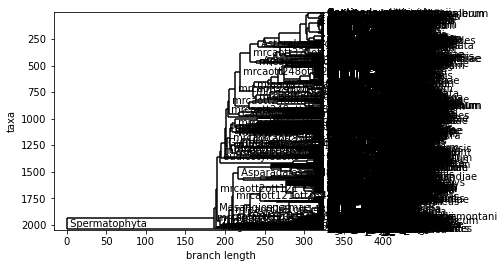

In [70]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 25))
Phylo.draw(tree, do_show=False)

# Images

_**NOTE:** I don’t know how to help with that package (sorry!) but just a related point:
If you’re planning to use iNat data for a publication of some sort, the preferred route of access is through GBIF which will give you a citeable doi for the dataset._

_Sometimes this isn’t an option if the dataset that you want contains records that aren’t on GBIF (like casual observations, which it looks like you may be wanting), but thought it worth a mention._

In [2]:
photos = pd.read_csv('inaturalist-open-data-20231027/photos.csv')

In [17]:
from pyinaturalist import get_taxa, pprint, Observation
import pyinaturalist as pi

In [40]:
spec = species.index[29]

In [46]:

# next(iter([]), None)

{'id': 402054,
 'rank': 'species',
 'rank_level': 10,
 'iconic_taxon_id': 47126,
 'ancestor_ids': [48460,
  47126,
  211194,
  47125,
  47124,
  47363,
  56235,
  794441,
  794443,
  60385,
  402054],
 'is_active': True,
 'name': 'Gentianella concinna',
 'parent_id': 60385,
 'ancestry': '48460/47126/211194/47125/47124/47363/56235/794441/794443/60385',
 'extinct': False,
 'default_photo': {'id': 61183939,
  'license_code': 'cc-by-nc',
  'attribution': '(c) Rowan Hindmarsh-Walls, some rights reserved (CC BY-NC), uploaded by Rowan Hindmarsh-Walls',
  'url': 'https://inaturalist-open-data.s3.amazonaws.com/photos/61183939/square.jpeg',
  'original_dimensions': {'height': 2048, 'width': 1153},
  'flags': [],
  'square_url': 'https://inaturalist-open-data.s3.amazonaws.com/photos/61183939/square.jpeg',
  'medium_url': 'https://inaturalist-open-data.s3.amazonaws.com/photos/61183939/medium.jpeg'},
 'taxon_changes_count': 2,
 'taxon_schemes_count': 2,
 'observations_count': 57,
 'flag_counts': {'

In [54]:
tmp = species.assign(inat_ids=ids)[['Features', 'inat_ids']]
tmp[tmp.inat_ids.isna()]

,Features,inat_ids
SpeciesName,,
coprosma-macrocarpa-subsp.-macrocarpa,,NaN
coprosma-propinqua-var.-martinii,,NaN
disphyma-australe-subsp.-stricticaule,,NaN
piper-excelsum-subsp.-psittacorum,,NaN
plagianthus-regius-subsp.-chathamicus,,NaN
sonchus-grandiflorus,,NaN
stellaria-decipiens-var.-angustata,,NaN
aciphylla-trailii,,NaN
azorella-exiguum,,NaN


In [48]:
get_id = lambda spec: next(iter(get_taxa(q=spec)['results']), None)['id']
ids = []
for spec in species.index:
	try:
		ids.append(get_id(spec))
	except:
		print(spec)
# species_ids = [get_id(species) for spec in species.index]

coprosma-macrocarpa-subsp.-macrocarpa
coprosma-propinqua-var.-martinii
disphyma-australe-subsp.-stricticaule
piper-excelsum-subsp.-psittacorum
plagianthus-regius-subsp.-chathamicus
sonchus-grandiflorus
stellaria-decipiens-var.-angustata
aciphylla-trailii
azorella-exiguum
cardamine-sciaphilia
rostkovia-magellanicum
ourisia-montana
polygonum-plebium
galium-antarctica
pimelea-telura


In [32]:
res_imgs = pi.get_observation_species_counts(taxon_id=[res['results'][0]['id']])

In [33]:
taxa = pi.TaxonCount.from_json_list(res_imgs['results'])
pprint(taxa)

                                                                     
  ID      Rank      Scientific name   Common name             Count  
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  48363   species   🌱 Tecoma stans   yellow trumpet flower   22058  
                                                                     


In [20]:
res['results'][0]['id']

48363

{'total_results': 5,
 'page': 1,
 'per_page': 30,
 'results': [{'id': 48363,
   'rank': 'species',
   'rank_level': 10,
   'iconic_taxon_id': 47126,
   'ancestor_ids': [48460,
    47126,
    211194,
    47125,
    47124,
    48151,
    48377,
    604091,
    48376,
    48363],
   'is_active': True,
   'name': 'Tecoma stans',
   'parent_id': 48376,
   'ancestry': '48460/47126/211194/47125/47124/48151/48377/604091/48376',
   'extinct': False,
   'default_photo': {'id': 59333691,
    'license_code': 'cc-by-nc-sa',
    'attribution': '(c) sergioniebla, some rights reserved (CC BY-NC-SA), uploaded by sergioniebla',
    'url': 'https://inaturalist-open-data.s3.amazonaws.com/photos/59333691/square.jpeg',
    'original_dimensions': {'height': 1365, 'width': 2048},
    'flags': [],
    'square_url': 'https://inaturalist-open-data.s3.amazonaws.com/photos/59333691/square.jpeg',
    'medium_url': 'https://inaturalist-open-data.s3.amazonaws.com/photos/59333691/medium.jpeg'},
   'taxon_changes_count

In [34]:
res = get_taxa(q="Tecoma stans")
# species.index[29]
Observation.from_id(res)

# get the images of the species


ObservationNotFound: 